# CSD 4: Baseline Prediction

## instructions

our course will be using an automatic grading system. <br>
after each question there will appear a code block with some prepared code to add your answer to a dictionary that will be sent to the course server for grading. <br>
please do not edit any code other than in placeholders marked `#### your code here ####` <br>
__don't forget to run the code block after you write your answer.__


you can add code blocks wherever you want in order to interact with datasets and play with your own code. <br>
in the next code block plase fill in your id number and email account in the appropriate placees. <br>

and __don't forget to run the block!__

In [1]:
ans = {}
ans['HW'] = 'CSD4'
ans['id_number'] = 307923383

0. For this Case Study assignment you should have in your current folder the ebay_boys_girls_shirts folder, holding the four CSV files describing the train and test shirts images, and the boys and girls images folders. This is what we did in CSD 1, **if you already have the data in your current folder you don't need to run this again!**:

In [2]:

import requests
import tarfile

if False:
    url = "http://www.tau.ac.il/~saharon/DScourse/ebay_boys_girls_shirts.tar.gz"
    r = requests.get(url)

    with open("ebay_boys_girls_shirts.tar", "wb") as file:
        file.write(r.content)

    with tarfile.open("ebay_boys_girls_shirts.tar") as tar:
        tar.extractall('.')

1. In this Case Study assignment we will try to classify an unseen shirt image as being of boys or of girls. We will use 20% of the data (training and test) for better speed, with Logistic Regression an Classification Trees.

    First we need the `x_train` and `x_test` matrices, and the `y_train` and `y_test` 0/1 vectors (0 = boys, 1 = girls).

    Previously on CSD2 and CSD3:

In [3]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images, files_list

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def numpy_array_size_in_bytes(a):
    return a.size * a.itemsize

Use the above functions to get the train and test matrices:

In [4]:
folder = 'ebay_boys_girls_shirts/'
n_train = 2000
n_test = 500

x_boys_train, boys_train_files = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
x_boys_test, boys_test_files = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)

x_girls_train, girls_train_files = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
x_girls_test, girls_test_files = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)


x_boys_train_all = get_all_pixels(x_boys_train)
x_boys_test_all = get_all_pixels(x_boys_test)

x_girls_train_all = get_all_pixels(x_girls_train)
x_girls_test_all = get_all_pixels(x_girls_test)

x_train = np.vstack([x_boys_train_all, x_girls_train_all])
x_test = np.vstack([x_boys_test_all, x_girls_test_all])

Now follow the example to create `y_train` and `y_test` 0/1 1D numpy arrays, the labelled data:

In [5]:
y_boys_train = np.array([np.uint8(0)] * x_boys_train.shape[0])
y_boys_test = np.array([np.uint8(0)] * x_boys_test.shape[0])
y_girls_train = np.array([np.uint8(1)] * x_girls_train.shape[0])
y_girls_test = np.array([np.uint8(1)] * x_girls_test.shape[0])

y_train = np.concatenate([y_boys_train, y_girls_train])
y_test = np.concatenate([y_boys_test, y_girls_test])

2. Always a good idea to print the shape of your matrices and their size to see there are no surprises:

In [6]:
def shape_and_size(x, name):
    n_rows = x.shape[0]
    if len(x.shape) == 1:
        n_cols = 1
    elif len(x.shape) == 2:
        n_cols = x.shape[1]
    else:
        warnings.warn('Function is meaningful for 1 or 2-D numpy arrays, taking 2nd dimension as n_cols')
        n_cols = x.shape[1]        
    size = numpy_array_size_in_bytes(x)
    print('%s Shape: %d X %d, Size (bytes): %d' % (name, n_rows, n_cols, size))

shape_and_size(x_train, 'x_train')
shape_and_size(x_test, 'x_test')
shape_and_size(y_train, 'y_train')
shape_and_size(y_test, 'y_test')

x_train Shape: 4000 X 30000, Size (bytes): 120000000
x_test Shape: 1000 X 30000, Size (bytes): 30000000
y_train Shape: 4000 X 1, Size (bytes): 4000
y_test Shape: 1000 X 1, Size (bytes): 1000


3. Start with the most basic, single predictor: the average pixel level. Can the average of all 30K pixels classify an unseen shirt image as being of boys or of girls with good accuracy?

    Get the average pixel:

In [7]:
x_train_av = x_train.mean(axis = 1).reshape(-1, 1) # we do the reshape step so that the shape would be (4000, 1), not (4000,)
x_test_av = x_test.mean(axis = 1).reshape(-1, 1)

shape_and_size(x_train_av, 'x_train_av')
shape_and_size(x_test_av, 'x_train_av')

x_train_av Shape: 4000 X 1, Size (bytes): 32000
x_train_av Shape: 1000 X 1, Size (bytes): 8000


Instantiate a Logistic Regression object using the [sklearn](https://scikit-learn.org/stable/) library.

In [8]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(solver='lbfgs')

Might want to make the model aware of your class names, or labels:

In [9]:
mod.classes_ = ['boys', 'girls']

Fit the model to training data:

In [10]:
mod.fit(x_train_av, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Get the actual Logistic Regression coefficients (we expect an intercept and a coefficient for the average pixel, the single predictor):

In [11]:
print('intercept:', mod.intercept_)
print('coefficient:', mod.coef_[0])

intercept: [-0.1856065]
coefficient: [0.00121881]


You have all you need to get the Logistic Regression different formulas:

In [12]:
print('Log-odds[label(image)=boys] = %.3f + (%.3f) X average_pixel' % (mod.intercept_, mod.coef_[0]))
print('Odds[label(image)=boys] = exp[%.3f + (%.3f) X average_pixel]' % (mod.intercept_, mod.coef_[0]))
print('Prob[label(image)=boys] = 1 / [1 + exp[%.3f + (%.3f) X average_pixel]]' % (mod.intercept_, mod.coef_[0]))

Log-odds[label(image)=boys] = -0.186 + (0.001) X average_pixel
Odds[label(image)=boys] = exp[-0.186 + (0.001) X average_pixel]
Prob[label(image)=boys] = 1 / [1 + exp[-0.186 + (0.001) X average_pixel]]


Get the predicted score on test set, which may be interpreted here as P(label(image) = boys):

(Make sure you can get these manually with the above formula!)

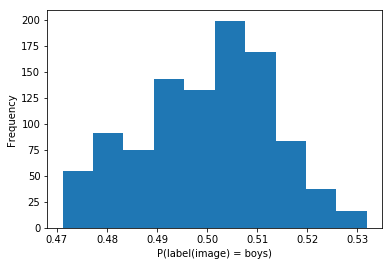

In [13]:
y_pred_prob = mod.predict_proba(x_test_av)

plt.hist(y_pred_prob[:, 0])
plt.xlabel('P(label(image) = boys)')
plt.ylabel('Frequency')
plt.show()

We can already see the scores are not "differentiated", as if they're completely random, and very close to 0.5 suggesting the model is "uncertain".

Since we used a balanced training set, it makes sence to have p = 0.5 as a cutoff threshold below which we predict "girls", above which we predict "boys".

Get the predicted label:

In [14]:
y_pred = mod.predict(x_test_av) # p=0.5 is the default cutoff

See the confusion matrix of predicted vs. true test labels:

In [15]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred)
print(conf)

[[285 215]
 [269 231]]


This is slightly not readable, so we'll get pandas to help:

In [16]:
y_test_s = np.array(['boys'] * len(y_test))
y_pred_s = np.array(['boys'] * len(y_test))
y_test_s[y_test == 1] = 'girls'
y_pred_s[y_pred == 1] = 'girls'

def conf_matrix(y_true, y_pred):
    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

conf_matrix(y_test_s, y_pred_s)

Predicted,boys,girl,All
True,,,
boys,285,215,500
girl,269,231,500
All,554,446,1000


4. You can see the average pixel preformed pretty bad in predicting the shirts images class. How do you measure it?

    You can use sklearn's automatic reports to get measures such as accuracy, recall and precision:

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test_s, y_pred_s))

              precision    recall  f1-score   support

        boys       0.51      0.57      0.54       500
        girl       0.52      0.46      0.49       500

   micro avg       0.52      0.52      0.52      1000
   macro avg       0.52      0.52      0.51      1000
weighted avg       0.52      0.52      0.51      1000



You can also manually calculate these metrics yourself from the `conf` matrix (make sure you know how!):

In [18]:
# accuracy = P(predict correct)
accuracy = (conf[0, 0] + conf[1, 1]) / len(y_test)

# recall(boys) = P(predict boys | label boys)
recall_boys = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))

# recall(girls) = P(predict girls | label girls)
recall_girls = (conf[1,1]) / (conf[1,1] + conf[1,0])

# precision(boys) = P(label boys | predict boys)
precision_boys = (conf[0,0]) / (conf[0,0] + conf[1,0]) 

# precision(boys) = P(label girls | predict girls)
precision_girls = (conf[1,1]) / (conf[1,1] + conf[0,1])

print('accuracy: %.2f' % accuracy)
print('recall_boys: %.2f' % recall_boys)
print('recall_girls: %.2f' % recall_girls)
print('precision_boys: %.2f' % precision_boys)
print('precision_girls: %.2f' % precision_girls)

accuracy: 0.52
recall_boys: 0.57
recall_girls: 0.46
precision_boys: 0.51
precision_girls: 0.52


In [19]:
ans['Q1'] = recall_girls
ans['Q2'] = precision_boys
ans['Q3'] = precision_girls

For quickly getting the overall accuracy, this would be the default option of the `score` method of any classification model fit object:

In [20]:
acc = mod.score(x_test_av, y_test)
print('Test accuracy on average pixel: %.2f' % acc)

Test accuracy on average pixel: 0.52


That's not impressive and close to random.

5. Let's try a model with 3 predictors: the average Red pixel, the average Green pixel and the average Blue pixel.

    First, get those:

In [21]:
def get_average_channel(x, channel):
    return x[:,:,:,channel].mean(axis = (1, 2)).reshape(-1, 1)

def get_channels(x):
    return np.hstack([get_average_channel(x, i) for i in range(3)])

x_boys_train_av_channels = get_channels(x_boys_train)
x_boys_test_av_channels = get_channels(x_boys_test)
x_girls_train_av_channels = get_channels(x_girls_train)
x_girls_test_av_channels = get_channels(x_girls_test)

x_train_av_channels = np.vstack([x_boys_train_av_channels, x_girls_train_av_channels])
x_test_av_channels = np.vstack([x_boys_test_av_channels, x_girls_test_av_channels])

shape_and_size(x_train_av_channels, 'x_train')
shape_and_size(x_test_av_channels, 'x_test')

x_train Shape: 4000 X 3, Size (bytes): 96000
x_test Shape: 1000 X 3, Size (bytes): 24000


Define the model, fit it, get log-odds formula and overall test accuracy, now in a single chunk:

In [22]:
mod = LogisticRegression(solver='lbfgs')
mod.fit(x_train_av_channels, y_train)

coef_names = ['red', 'green', 'blue']
coef = mod.coef_[0]
print('log-odds: %.3f + %.3f * %s + %.3f * %s + %.3f * %s' %
      (mod.intercept_, coef[0], coef_names[0], coef[1], coef_names[1], coef[2], coef_names[2]))

acc = mod.score(x_test_av_channels, y_test)
print('Test accuracy on 3 channels with LR: %.3f' % acc)

log-odds: -0.364 + 0.008 * red + -0.011 * green + 0.004 * blue
Test accuracy on 3 channels with LR: 0.560


In [23]:
ans['Q4'] = coef
ans['Q5'] = acc

The test accuracy is slightly better than when using a global average pixel but we cannot say for sure if that's not by random.

7. How about Logistic Regression with all 30K pixels?

In [24]:
mod = LogisticRegression(solver='lbfgs', max_iter = 100) # have a look at LogisticRegression default parameters in the docs
mod.fit(x_train, y_train)

acc = mod.score(x_test, y_test)
print('Test accuracy on all pixels with LR: %.3f' % acc)

/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Test accuracy on all pixels with LR: 0.684


Much more impressive, let's look at the confusion matrix now:

In [25]:
y_pred = mod.predict(x_test)

y_pred_s = np.array(['boys'] * len(y_test))
y_pred_s[y_pred == 1] = 'girls'


display(conf_matrix(y_test_s, y_pred_s))
conf_all_pixels = confusion_matrix(y_test_s, y_pred_s); conf_all_pixels

Predicted,boys,girl,All
True,,,
boys,335,165,500
girl,151,349,500
All,486,514,1000


array([[335, 165],
       [151, 349]])

In [26]:
conf_all_pixels

array([[335, 165],
       [151, 349]])

report the following:<br>
__Q6)__ recall: girls<br>
__Q7)__ precision: boys<br>
__Q8)__ precision: girls

In [27]:
recall_girls = (conf_all_pixels[1,1]) / (conf_all_pixels[1,1] + conf_all_pixels[1,0])
precision_boys = (conf_all_pixels[0,0]) / (conf_all_pixels[0,0] + conf_all_pixels[1,0]) 
precision_girls = (conf_all_pixels[1,1]) / (conf_all_pixels[1,1] + conf_all_pixels[0,1])

print(classification_report(y_test_s, y_pred_s, digits=3))
recall_girls, precision_boys, precision_girls

              precision    recall  f1-score   support

        boys      0.689     0.670     0.680       500
        girl      0.679     0.698     0.688       500

   micro avg      0.684     0.684     0.684      1000
   macro avg      0.684     0.684     0.684      1000
weighted avg      0.684     0.684     0.684      1000



(0.698, 0.6893004115226338, 0.6789883268482491)

In [28]:
ans['Q6'] = recall_girls
ans['Q7'] = precision_boys
ans['Q8'] = precision_girls

Also make sure that the predicted probability score histogram looks better, more "differentiated":

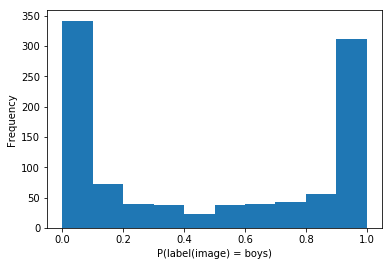

In [29]:
y_pred_prob = mod.predict_proba(x_test)

plt.hist(y_pred_prob[:, 0])
plt.xlabel('P(label(image) = boys)')
plt.ylabel('Frequency')
plt.show()

8. It is interesting to see the accuracy for images with very low and very high predicted probability score. If we took the "girls, boys, don't know" strategy, how better off would we be?

In [30]:
y_pred_prob_1d = y_pred_prob[:, 0]
y_pred_low_high_id = np.argwhere(( y_pred_prob_1d <= 0.001) | (y_pred_prob_1d >= 0.999)).reshape(-1)
y_pred_low_high = y_pred_prob[y_pred_low_high_id, 0]
y_pred_low_high_temp = y_pred_low_high.copy()
y_pred_low_high[y_pred_low_high_temp < 0.5] = 1
y_pred_low_high[y_pred_low_high_temp > 0.5] = 0
y_test_low_high = y_test[y_pred_low_high_id]

conf = confusion_matrix(y_test_low_high, y_pred_low_high)
acc = (conf[0, 0] + conf[1, 1]) / len(y_test_low_high)
print('Test accuracy on all pixels with LR, only %.2f of images with very low/high scores: %.3f' % (len(y_test_low_high)/len(y_test), acc))

Test accuracy on all pixels with LR, only 0.22 of images with very low/high scores: 0.810


In [31]:
ans['Q9'] = acc

# finish!

to submit your HW please run this last code block and follow the instructions.
this code will create a CSV file in the current directory on the azure notebooks project
please download it and submit it through moodle


In [32]:
import pandas as pd
df_ans = pd.DataFrame.from_dict(ans, orient='index')
if df_ans.shape[0] == 11:
    df_ans.to_csv('{}_{}.csv'.format(ans['HW'],str(ans['id_number'])))
    print("OK!")
else:
    print("seems like you missed a question, make sure you have run all the code blocks")

OK!
